In [25]:
import sys
ros_path = '/opt/ros/kinetic/lib/python2.7/dist-packages'
if ros_path in sys.path:
    sys.path.remove(ros_path)
import cv2 as cv
sys.path.append('/opt/ros/kinetic/lib/python2.7/dist-packages')
import matplotlib.pyplot as plt
from matplotlib.colors import NoNorm
from PIL import Image
import numpy as np
result_folder = 'result_new_1500'

In [10]:
import math
def data2gray(data_input,size):
    size=[size[1],size[0]]
    data_np=np.array(data_input)
    data_np=np.flipud(data_np)
    data_np=np.rot90(data_np,1)
    data_np_rs=np.uint8(data_np)
    data_np=data_np.reshape(size[0]*size[1],)
    return data_np, data_np_rs

def data2nfgray(data_input,size):
    size=[size[1],size[0]]
    data_np=np.array(data_input)
    data_np=np.flipud(data_np)
    data_np_rs=np.uint8(data_np)
    data_np=data_np.reshape(size[0]*size[1],)
    return data_np, data_np_rs

In [28]:
def use_orb(data1,data2,name_exp):
    # find the keypoints and descriptors with ORB
    orb = cv.ORB_create(nfeatures=1500)
    kp1, des1 = orb.detectAndCompute(data1,None)
    kp2, des2 = orb.detectAndCompute(data2,None)
    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=6,table_number=6,key_size=12,multi_probe_level=2)
    search_params = {}
    flann = cv.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    print(len(matches))
    good=[]
    # Need to draw only good matches, so create a mask
    matchesMask = [[0,0] for i in range(len(matches))]
    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.75*n.distance:
            matchesMask[i]=[1,0]
            good.append(m)
    draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv.DrawMatchesFlags_DEFAULT)
    img3 = cv.drawMatchesKnn(data1,kp1,data2,kp2,matches,None,**draw_params)

    dst_pt = np.array([ kp2[m.trainIdx].pt for m in good ])
    src_pt = np.array([ kp1[m.queryIdx].pt for m in good ])
    

    plt.subplot(121), plt.imshow(data1,cmap='gray', vmin=0, vmax=255), plt.title('ORB_Map1')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(data2,cmap='gray', vmin=0, vmax=255), plt.title('ORB_Map2')
    plt.xticks([]), plt.yticks([])
    plt.show()

    plt.imshow(img3,),plt.show()
    #cv.imwrite("siftr.png",img3)
    plt.scatter(dst_pt[:, 0], dst_pt[:, 1], 80, 'r', '^')
    plt.scatter(src_pt[:, 0], src_pt[:, 1], 80, 'g', '*')
    plt.gca().invert_yaxis()
    plt.show()

    ret, inliers = cv.estimateAffine2D(dst_pt, src_pt)
#    M, mask = cv.findHomography(src_pt, dst_pt, cv.RANSAC,5.0)
    data2_rot = cv.warpAffine(data2,ret,(3000, 3000))
    plt.subplot(121), plt.imshow(data1,cmap='gray', vmin=0, vmax=255), plt.title('ORB_Map1')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(data2_rot,cmap='gray', vmin=0, vmax=255), plt.title('ORB_Map2_ROT')
    plt.xticks([]), plt.yticks([])
    plt.show()
    filename_rel = result_folder + '/' + 'orb/' + name_exp + '.txt'
    with open(filename_rel, "w") as f:
        f.write('T=\n')
        for line in ret:
            np.savetxt(f, line, fmt='%.2f')
        f.write('Matches=\n' + str(len(dst_pt)) +'\n')
        f.write('inliers=\n' + str(len(inliers[inliers>0])) +'\n')
    filename_rot = result_folder + '/' + 'orb/' + name_exp +'_rot.png'
    filename_cmp = result_folder + '/' + 'orb/' + name_exp +'_cmp.png'
    filename_org = result_folder + '/' + 'orb/' + name_exp +'_org.png'
    cv.imwrite(filename_org,data2)
    cv.imwrite(filename_cmp,img3)
    cv.imwrite(filename_rot,data2_rot)
    print(filename_rel)
    return ret, inliers, len(dst_pt)

In [29]:
def use_sift(data1,data2,name_exp):
    # find the keypoints and descriptors with SIFT
    sift = cv.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(data1,None)
    kp2, des2 = sift.detectAndCompute(data2,None)
    # FLANN parameters
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    print(len(matches))
    good=[]
    # Need to draw only good matches, so create a mask
    matchesMask = [[0,0] for i in range(len(matches))]
    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.75*n.distance:
            matchesMask[i]=[1,0]
            good.append(m)
    draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv.DrawMatchesFlags_DEFAULT)
    img3 = cv.drawMatchesKnn(data1,kp1,data2,kp2,matches,None,**draw_params)

    dst_pt = np.array([ kp2[m.trainIdx].pt for m in good ])
    src_pt = np.array([ kp1[m.queryIdx].pt for m in good ])
    
    plt.subplot(121), plt.imshow(data1,cmap='gray', vmin=0, vmax=255), plt.title('SIFT_Map1')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(data2,cmap='gray', vmin=0, vmax=255), plt.title('SIFT_Map2')
    plt.xticks([]), plt.yticks([])
    plt.show()    
    
    plt.imshow(img3,),plt.show()
    #cv.imwrite("siftr.png",img3)
    plt.scatter(dst_pt[:, 0], dst_pt[:, 1], 80, 'r', '^')
    plt.scatter(src_pt[:, 0], src_pt[:, 1], 80, 'g', '*')
    plt.gca().invert_yaxis()
    plt.show()
    ret, inliers = cv.estimateAffine2D(dst_pt, src_pt)
#    M, mask = cv.findHomography(src_pt, dst_pt, cv.RANSAC,5.0)
    data2_rot = cv.warpAffine(data2,ret,(3000, 3000))
    plt.subplot(121), plt.imshow(data1,cmap='gray', vmin=0, vmax=255), plt.title('SIFT_Map1')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(data2_rot,cmap='gray', vmin=0, vmax=255), plt.title('SIFT_Map2_ROT')
    plt.xticks([]), plt.yticks([])
    plt.show()
    filename_rel = result_folder + '/' + 'sift' + name_exp + '.txt'
    with open(filename_rel, "w") as f:
        f.write('T=\n')
        for line in ret:
            np.savetxt(f, line, fmt='%.2f')
        f.write('Matches=\n' + str(len(dst_pt)) +'\n')
        f.write('inliers=\n' + str(len(inliers[inliers>0])) +'\n')
    filename_rot = result_folder + '/' + 'sift/' + name_exp +'_rot.png'
    filename_cmp = result_folder + '/' + 'sift/' + name_exp +'_cmp.png'
    filename_org = result_folder + '/' + 'sift/' + name_exp +'_org.png'
    cv.imwrite(filename_org,data2)
    cv.imwrite(filename_cmp,img3)
    cv.imwrite(filename_rot,data2_rot)   
    print(filename_rel)
    return ret, inliers, len(dst_pt)

In [20]:
def print_result(T, inliers, mateches):
    print (T[0][0]*T[0][0]+T[0][1]*T[0][1])
    print (np.arccos(T[0][0])/2/np.pi*360)
    print (np.arcsin(T[0][1])/2/np.pi*360)
    print (T)
    print ("Matches: ",mateches)
    print ("Numbers of inliers: ",len(inliers[inliers>0]))

In [21]:
def rotate_image(image, angle, x_shift, y_shift):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv.getRotationMatrix2D(image_center, angle, 1.0)
#    print(rot_mat)
#    result = cv.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv.INTER_LINEAR)
    result = cv.warpAffine(image, rot_mat, (3000,3000))
    rot_shift = np.array(([1,0,x_shift],[0,1,y_shift]),dtype=np.float32)
#    print(rot_shift)
    result = cv.warpAffine(result ,rot_shift, (3000,3000))
    return result

(950, 1163)
(950, 1163)


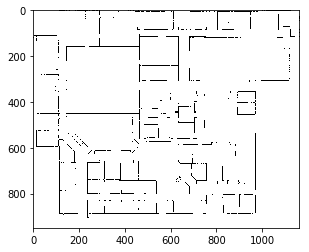

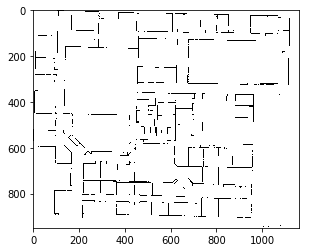

(<matplotlib.image.AxesImage at 0x7f4af5885b38>, None)

In [22]:
map_data_0 = cv.imread("wg_1/willow_full.pgm",0)
map_data_1 = cv.imread("wg_2/willowgarage.pgm",0)
map_data_0 = map_data_0[750:2000,750:2000]
map_data_1 = map_data_1[1350:2600,1550:2800]
map_data_0[map_data_0>199]=255
map_data_1[map_data_1>199]=255

map_data_0 = map_data_0[167:1117,58:1221]
map_data_1 = map_data_1[153:1103,66:1229]

map_size_0 = map_data_0.shape
map_size_1 = map_data_1.shape
print(map_size_0)
print(map_size_1)

plt.gca().invert_yaxis()
plt.imshow(map_data_0,cmap='gray', vmin=0, vmax=255),plt.show()
plt.gca().invert_yaxis()
plt.imshow(map_data_1,cmap='gray', vmin=0, vmax=255),plt.show()

(1163, 950)
(950, 1163)


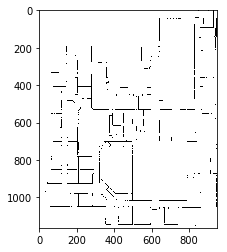

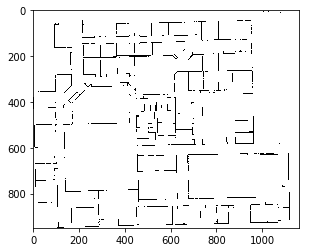

(<matplotlib.image.AxesImage at 0x7f4af59bfb00>, None)

In [23]:
data_ns_0, data_0 = data2gray(map_data_0, map_size_0)
data_ns_1, data_1 = data2nfgray(map_data_1, map_size_1)
print(data_0.shape)
print(data_1.shape)

plt.gca().invert_yaxis()
plt.imshow(data_0,cmap='gray', vmin=0, vmax=255),plt.show()
#cv.imwrite('d0_100.png',data_0)


plt.gca().invert_yaxis()
plt.imshow(data_1,cmap='gray', vmin=0, vmax=255),plt.show()
#cv.imwrite('d1_100.png',data_1)

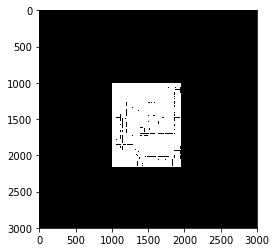

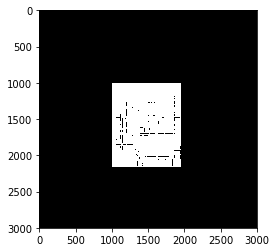

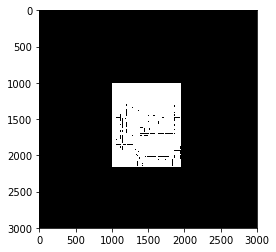

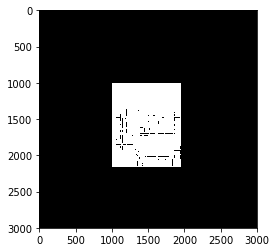

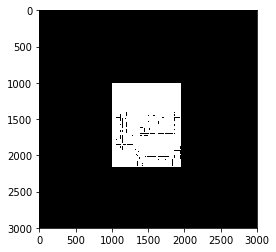

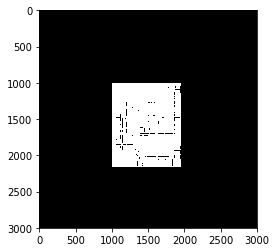

True

In [26]:
data_ns_0, data_0 = data2gray(map_data_0, map_size_0)
data_ns_1, data_1 = data2nfgray(map_data_1, map_size_1)

map_size_0 = data_0.shape
map_size_1 = data_1.shape

data_0_90 = data_0.copy()
data_0_90[0:int(data_0.shape[0]*0.05)] = 255
data_0_90 = rotate_image(data_0_90,0,1000,1000)
plt.gca().invert_yaxis()
plt.imshow(data_0_90, cmap='gray',vmin=0, vmax=255),plt.show()
cv.imwrite(result_folder + '/' + 'org/d0_90_r.png',data_0_90)

data_0_70 = data_0.copy()
data_0_70[0:int(data_0.shape[0]*0.15)] = 255
data_0_70 = rotate_image(data_0_70,0,1000,1000)
plt.gca().invert_yaxis()
plt.imshow(data_0_70, cmap='gray',vmin=0, vmax=255),plt.show()
cv.imwrite(result_folder + '/' + 'org/d0_70_r.png',data_0_70)

data_0_50 = data_0.copy()
data_0_50[0:int(data_0.shape[0]*0.25)] = 255
data_0_50 = rotate_image(data_0_50,0,1000,1000)
plt.gca().invert_yaxis()
plt.imshow(data_0_50, cmap='gray',vmin=0, vmax=255),plt.show()
cv.imwrite(result_folder + '/' + 'org/d0_50_r.png',data_0_50)

data_0_40 = data_0.copy()
data_0_40[0:int(data_0.shape[0]*0.30)] = 255
data_0_40 = rotate_image(data_0_40,0,1000,1000)
plt.gca().invert_yaxis()
plt.imshow(data_0_40, cmap='gray',vmin=0, vmax=255),plt.show()
cv.imwrite(result_folder + '/' + 'org/d0_40_r.png',data_0_40)

data_0_30 = data_0.copy()
data_0_30[0:int(data_0.shape[0]*0.35)] = 255
data_0_30 = rotate_image(data_0_30,0,1000,1000)
plt.gca().invert_yaxis()
plt.imshow(data_0_30, cmap='gray',vmin=0, vmax=255),plt.show()
cv.imwrite(result_folder + '/' + 'org/d0_30_r.png',data_0_30)

data_0 = rotate_image(data_0,0,1000,1000)
plt.gca().invert_yaxis()
plt.imshow(data_0, cmap='gray',vmin=0, vmax=255),plt.show()
cv.imwrite(result_folder + '/' + 'org/d0_100_r.png',data_0)

1501


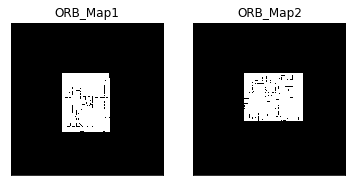

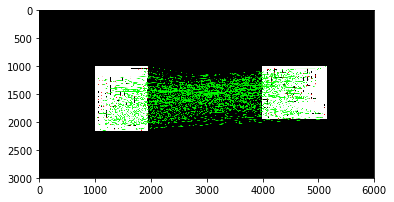

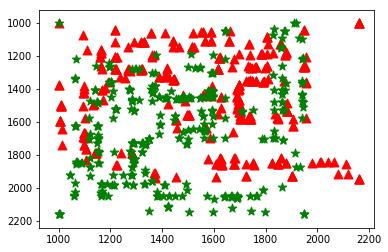

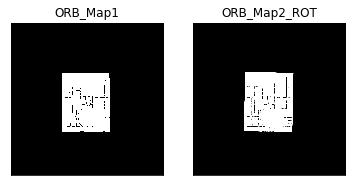

result_new_1500/orb/orb_100_0_0_0.txt
1444


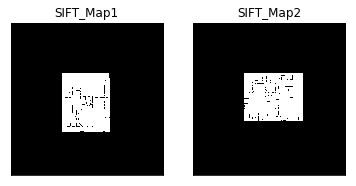

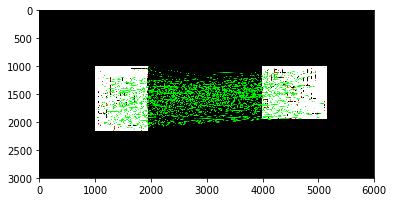

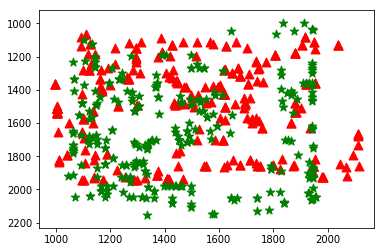

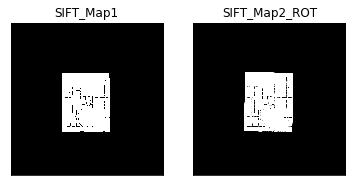

result_new_1500/siftsift_100_0_0_0.txt
1500


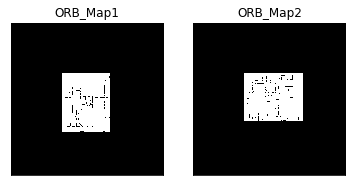

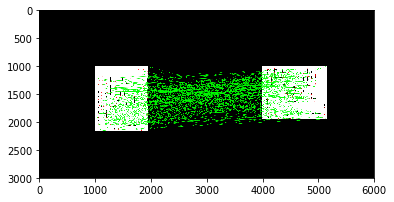

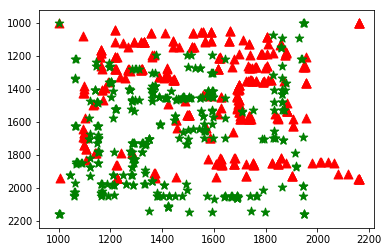

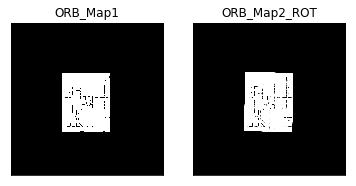

result_new_1500/orb/orb_90_0_0_0.txt
1411


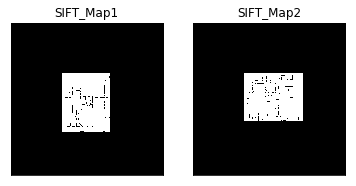

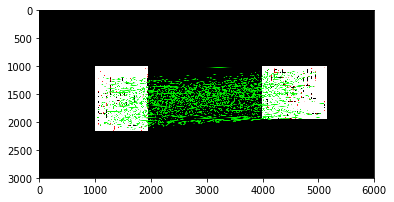

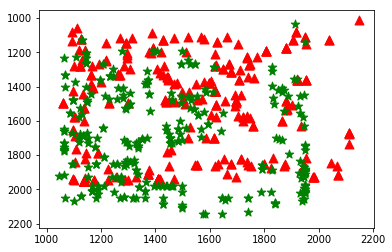

KeyboardInterrupt: 

In [30]:
for t_degree in range(0, 340, 30):
    for x_shift in range(0, 500, 50):
        for y_shift in range(0, 500, 50):
            data_1_r = rotate_image(data_1,0,1000,1000)
            data_1_r = rotate_image(data_1_r, t_degree, x_shift, y_shift)
#            plt.gca().invert_yaxis()
#            plt.imshow(data_1_r, cmap='gray',vmin=0, vmax=255),plt.show()
            cv.imwrite(result_folder + '/' + 'rot/d1_100_r' + '_' + str(t_degree) + '_' + str(x_shift) + '_' + str(y_shift) + '_' + '.png',data_1_r)

            data_1_90 = data_1.copy()
            data_1_90[:,0:int(data_1.shape[1]*0.05)] = 255
            data_1_90 = rotate_image(data_1_90,0,1000,1000)
            data_1_90 = rotate_image(data_1_90, t_degree, x_shift, y_shift)
#            plt.gca().invert_yaxis()
#            plt.imshow(data_1_90, cmap='gray',vmin=0, vmax=255),plt.show()
            cv.imwrite(result_folder + '/' + 'rot/d1_90_r' + '_' + str(t_degree) + '_' + str(x_shift) + '_' + str(y_shift) + '_' + '.png',data_1_90)

            data_1_70 = data_1.copy()
            data_1_70[:,0:int(data_1.shape[1]*0.15)] = 255
            data_1_70 = rotate_image(data_1_70,0,1000,1000)
            data_1_70 = rotate_image(data_1_70, t_degree, x_shift, y_shift)
#            plt.gca().invert_yaxis()
#            plt.imshow(data_1_70, cmap='gray',vmin=0, vmax=255),plt.show()
            cv.imwrite(result_folder + '/' + 'rot/d1_70_r' + '_' + str(t_degree) + '_' + str(x_shift) + '_' + str(y_shift) + '_' + '.png',data_1_70)

            data_1_50 = data_1.copy()
            data_1_50[:,0:int(data_1.shape[1]*0.25)] = 255
            data_1_50 = rotate_image(data_1_50,0,1000,1000)
            data_1_50 = rotate_image(data_1_50, t_degree, x_shift, y_shift)
#            plt.gca().invert_yaxis()
#            plt.imshow(data_1_50, cmap='gray',vmin=0, vmax=255),plt.show()
            cv.imwrite(result_folder + '/' + 'rot/d1_50_r' + '_' + str(t_degree) + '_' + str(x_shift) + '_' + str(y_shift) + '_' + '.png',data_1_50)

            data_1_40 = data_1.copy()
            data_1_40[:,0:int(data_1.shape[1]*0.30)] = 255
            data_1_40 = rotate_image(data_1_40,0,1000,1000)
            data_1_40 = rotate_image(data_1_40, t_degree, x_shift, y_shift)

#            plt.gca().invert_yaxis()
#            plt.imshow(data_1_40, cmap='gray',vmin=0, vmax=255),plt.show()
            cv.imwrite(result_folder + '/' + 'rot/d1_40_r' + '_' + str(t_degree) + '_' + str(x_shift) + '_' + str(y_shift) + '_' + '.png',data_1_40)

            data_1_30 = data_1.copy()
            data_1_30[:,0:int(data_1.shape[1]*0.35)] = 255
            data_1_30 = rotate_image(data_1_30,0,1000,1000)
            data_1_30 = rotate_image(data_1_30, t_degree, x_shift, y_shift)
#            plt.gca().invert_yaxis()
#            plt.imshow(data_1_30, cmap='gray',vmin=0, vmax=255),plt.show()
            cv.imwrite(result_folder + '/' + 'rot/d1_30_r' + '_' + str(t_degree) + '_' + str(x_shift) + '_' + str(y_shift) + '_' + '.png',data_1_30)

            ret_orb_100, inliers_orb_100, matches_orb_100 = use_orb(data_0,data_1_r,'orb_100' + '_' + str(t_degree) + '_' + str(x_shift) + '_' + str(y_shift))
            #print_result(ret_orb_100, inliers_orb_100, matches_orb_100)
            ret_sift_100, inliers_sift_100, matches_sift_100 = use_sift(data_0,data_1_r,'sift_100' + '_' + str(t_degree) + '_' + str(x_shift) + '_' + str(y_shift))
            #print_result(ret_sift_100, inliers_sift_100, matches_sift_100)
            #ret_corners_100, inliers_corners_100, matches_corners_100 = use_corners(data_0,data_1)
            #print_result(ret_corners_100, inliers_corners_100, matches_corners_100)
            ret_orb_90, inliers_orb_90, matches_orb_90 = use_orb(data_0_90,data_1_90,'orb_90' + '_' + str(t_degree) + '_' + str(x_shift) + '_' + str(y_shift))
            #print_result(ret_orb_90, inliers_orb_90, matches_orb_90)
            ret_sift_90, inliers_sift_90, matches_sift_90 = use_sift(data_0_90,data_1_90,'sift_90' + '_' + str(t_degree) + '_' + str(x_shift) + '_' + str(y_shift))
            #print_result(ret_sift_90, inliers_sift_90, matches_sift_90)

            ret_orb_70, inliers_orb_70, matches_orb_70 = use_orb(data_0_70,data_1_70,'orb_70' + '_' + str(t_degree) + '_' + str(x_shift) + '_' + str(y_shift))
            #print_result(ret_orb_70, inliers_orb_70, matches_orb_70)
            ret_sift_70, inliers_sift_70, matches_sift_70 = use_sift(data_0_70,data_1_70,'sift_70' + '_' + str(t_degree) + '_' + str(x_shift) + '_' + str(y_shift))
            #print_result(ret_sift_70, inliers_sift_70, matches_sift_70)

            ret_orb_50, inliers_orb_50, matches_orb_50 = use_orb(data_0_50,data_1_50,'orb_50' + '_' + str(t_degree) + '_' + str(x_shift) + '_' + str(y_shift))
            #print_result(ret_orb_50, inliers_orb_50, matches_orb_50)
            ret_sift_50, inliers_sift_50, matches_sift_50 = use_sift(data_0_50,data_1_50,'sift_50' + '_' + str(t_degree) + '_' + str(x_shift) + '_' + str(y_shift))
            #print_result(ret_sift_50, inliers_sift_50, matches_sift_50)

            ret_orb_40, inliers_orb_40, matches_orb_40 = use_orb(data_0_40,data_1_40,'orb_40' + '_' + str(t_degree) + '_' + str(x_shift) + '_' + str(y_shift))
            #print_result(ret_orb_40, inliers_orb_40, matches_orb_40)
            ret_sift_40, inliers_sift_40, matches_sift_40 = use_sift(data_0_50,data_1_40,'sift_40' + '_' + str(t_degree) + '_' + str(x_shift) + '_' + str(y_shift))
            #print_result(ret_sift_40, inliers_sift_40, matches_sift_40)
            
            ret_orb_30, inliers_orb_30, matches_orb_30 = use_orb(data_0_30,data_1_30,'orb_30' + '_' + str(t_degree) + '_' + str(x_shift) + '_' + str(y_shift))
            #print_result(ret_orb_30, inliers_orb_30, matches_orb_30)
            ret_sift_30, inliers_sift_30, matches_sift_30 = use_sift(data_0_30,data_1_30,'sift_30' + '_' + str(t_degree) + '_' + str(x_shift) + '_' + str(y_shift))